# Box Office Predictions

All imports used in the project are collected here at the top. Some of these might not have been used in the end

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import sklearn
import ast
import catboost
import statistics
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from functools import partial
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

## Framing the problem and looking at the big picture

The objective of our machine learning algorithm is to accurately predict a movie's revenue based on data from an online movie database. These predictions might give useful insights into what makes a movie successful for future reference. 

The data we get to play with already have the revenue made for each movie. This means that we have supervised learning. It's also a regression task, since we're trying to predict a number, how much the movie made. 

## Getting the data

The data is from the competition page on kaggle. 

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Exploring the data and getting insights

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


A section of the data set. There are 23 columns and many different data types like strings, dictionaries and some numeric types like ints and floats. We need to find ways to get relevant training data from these objects. 

Just from these first five rows we see there are lots of data missing. Let's take a better look at that. 

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In the train set there are 3000 entries. Many of the 23 columns are missing data. Columns ``belongs_to_collection`` and ``homepage`` are especially sparse with data.

While most of the columns are objects (strings, lists, dictionaries), there are a few numerical ones: ``id``, ``budget``, ``popularity``, ``runtime`` and of course ``revenue``. One can imagine that there is already some amount of correlation between these columns. Budget and popularity especially stands out as obvious choices for correlation. Let's check. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E1226536A0>,
      dtype=object)

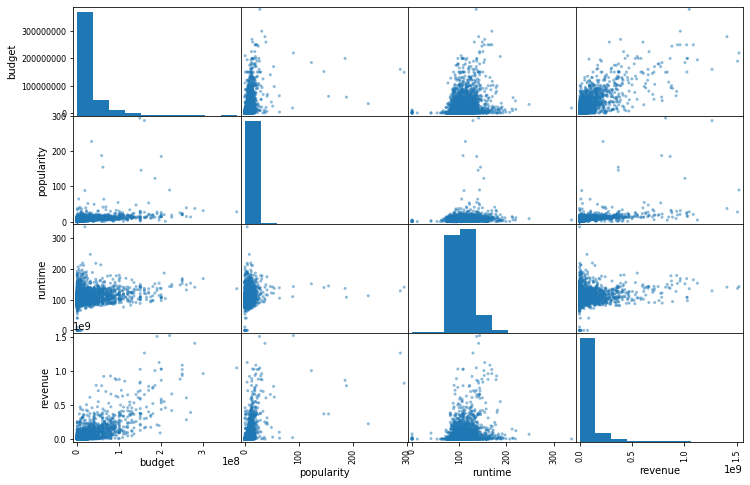

In [5]:
attributes = ["budget", "popularity", "runtime", "revenue"]
scatter_matrix(train[attributes], figsize=(12,8))

We plot the attributes in a scatter matrix. The only obvious correlation to be seen here is indeed ``revenue`` and ``budget``. 

However, ``revenue`` and ``popularity`` does not seem to correlated, which is surprising. Let's have a closer look at that relation:

(0, 180000000)

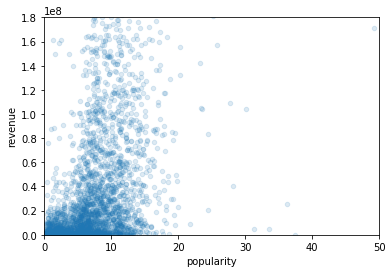

In [6]:
train.plot(kind="scatter", x="popularity", y="revenue", alpha=0.15)
plt.xlim(0,50)
plt.ylim(0,180000000)


This looks like a mess. One can see that movies with a popularity with less than ~5 (whatever that number means) tend to not make too much money. There are exceptions to this though. 

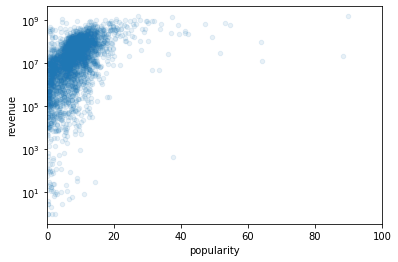

In [7]:
train.plot(kind="scatter", x="popularity", y="revenue", alpha=0.1)
plt.xlim(0,100)
plt.yscale("log")

Plotting it logarithmically looks a bit less messy, but it's hard to get useful info from this one too. The movies that are the most popular tend to have the highest revenue, with few exceptions.

It seems hard to get information from this attribute.

Let's also have a quick look at the ``budget`` and ``revenue`` correlation:

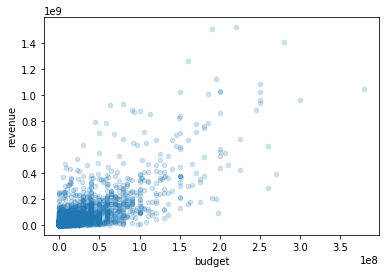

In [8]:
train.plot(kind="scatter", x="budget", y="revenue", alpha=0.2)

We can see that the budget value is often a round number. Patterns/lines are forming at the different million-marks. 

There is also a lot more correlation compared to popularity. 

But we also have to look at the columns that are not initially number types, and see if there are some other correlations with revenue. To do this, we have to prepare the data.

## Preparing the data

In [9]:
train_copy = train.copy()
test_copy = test.copy()

We make some copies which we will use from here on out.

### belongs_to_collection and homepage

In [10]:
def collectionBooleanifier(collection):

    new_collection = []

    new_val = 0
    for x in collection:
        if x != x:
            new_val = 0
        else:
            new_val = 1
        new_collection.append(new_val) 
        
    return new_collection

In [11]:
train_copy['has_collection'] = collectionBooleanifier(train_copy['belongs_to_collection'])
train_copy['has_homepage'] = collectionBooleanifier(train_copy['homepage'])
test_copy['has_collection'] = collectionBooleanifier(test_copy['belongs_to_collection'])
test_copy['has_homepage'] = collectionBooleanifier(test_copy['homepage'])

train_copy = train_copy.drop(['belongs_to_collection'], axis=1)
train_copy = train_copy.drop(['homepage'], axis=1)
test_copy = test_copy.drop(['belongs_to_collection'], axis=1)
test_copy = test_copy.drop(['homepage'], axis=1)

The first data we replace is the collection objects. We decided to just check if a movie was a part of a collection or not. We thought we could make a new column for each unique collection and check if the movie was part of any (kinda like one hot encoding), but we were unsure if that would give more results and it seemed like a lot of work and extra columns for little gain. 

The function ``collectionBooleanifier`` could be used for both collection and homepage. 

Let's take a quick look at these new attributes:

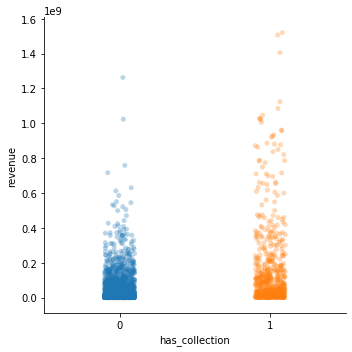

In [12]:
sns.catplot(x="has_collection", y="revenue", alpha=0.3, data=train_copy)

It looks like movies that are part of a collection have higher revenues. 

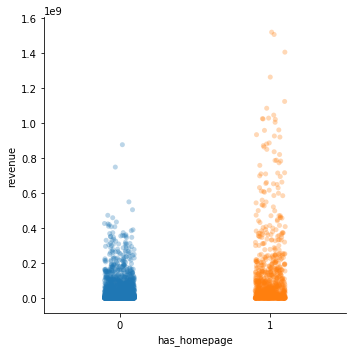

In [13]:
sns.catplot(x="has_homepage", y="revenue", alpha=0.3, data=train_copy)

Interestingly, the same can be said about hompage. Maybe this is because bigger movies tend to have homepages, but smaller movies don't?  

### Spoken language

Now let's look at the ``spoken_languages`` column

In [14]:
langs = train_copy['spoken_languages'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

Here we make a temporary list for practical purposes. This lambda expression goes through the list and converts the string representation of list of dictionaries into *actual* list of dictionaries.

In [15]:
print('Number of spoken languages in films')

langs.apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [16]:
list_of_languages = list(langs.apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

Looking at these data we can clearly see that there are many more movies in english than non-english. English is 10 times as popular as the second biggest language, french. 

Therefore, we decided to just have one variable ``has_english`` to replace spoken languages. This variable is ``1`` if the movie is in english (or has english spoken in it at all), and ``0`` otherwise.

In [17]:
def language_encoder(column, length):

    new_lang = [0] * length
    
    i = 0
    for x in column:
        if x == x:
            ds = ast.literal_eval(x)
            if any(d['iso_639_1'] == 'en' for d in ds): 
                new_lang[i] = 1
        else:
            new_lang[i] = 1 #if the movie doesn't specify spoken language we assume it's english, just by probability. 
        i+=1
    
    return new_lang

In [18]:
train_copy['has_english'] = language_encoder(train_copy['spoken_languages'], 3000)
test_copy['has_english'] = language_encoder(test_copy['spoken_languages'], 4398)

train_copy = train_copy.drop(['spoken_languages'], axis=1)
test_copy = test_copy.drop(['spoken_languages'], axis=1)

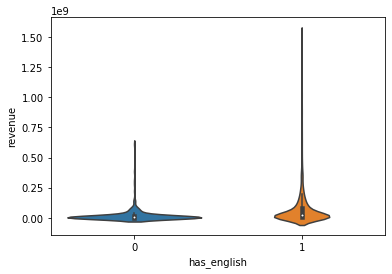

In [19]:
sns.violinplot(x="has_english", y="revenue", data=train_copy)

We see that the non-english movies tend to have lower revenue, while english movies vary a bit more. This makes sense, one could imagine that there is a bigger marked for movies in english.

### Cast and Crew

Next up is the cast and crew columns. First: let's open up these objects and check out what hides inside them!

In [20]:
ast.literal_eval(train_copy['cast'][0])

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'prof

In [21]:
ast.literal_eval(train_copy['crew'][0])

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36

All these three columns are lists of dictionaries. That means there's a lot of data in each of them. Just looking at cast alone, there are lots of information for each actor. One could imagine some specific actors increasing the popularity of movies and therefore also revenue.

However, we didn't think we would gain much from adding individual columns for actors. Instead we thoguht the size of the cast and the gender-distribution of the cast were more interesting attributes, and thought these maybe had an impact on the revenue.

So we made a function that did that on cast:

In [22]:
def cast_counter(column):
    cast_size = [0] * len(column)
    male_cast_size = [0] * len(column)
    female_cast_size = [0] * len(column)
    uncategorized_cast_size = [0] * len(column)
    
    i = 0
    for cast_list_str in column:
        
        if cast_list_str == cast_list_str:
            cast_list = ast.literal_eval(cast_list_str)
            cast_size[i] = len(cast_list)
            
            for cast in cast_list:
                if(cast['gender'] == 1):
                    female_cast_size[i] += 1
                elif(cast['gender'] == 2):
                    male_cast_size[i] += 1
                else:
                    uncategorized_cast_size[i] += 1
            
        else:
            cast_size[i] = np.nan
            female_cast_size[i] = np.nan
            male_cast_size[i] = np.nan
            uncategorized_cast_size[i] = np.nan
        i+=1
    
    return cast_size, female_cast_size, male_cast_size, uncategorized_cast_size

In [23]:
train_copy['cast_size'], train_copy['female_cast_size'], train_copy['male_cast_size'], train_copy['uncategorized_cast_size'] = cast_counter(train_copy['cast'])
train_copy = train_copy.drop('cast', axis = 1)

test_copy['cast_size'], test_copy['female_cast_size'], test_copy['male_cast_size'], test_copy['uncategorized_cast_size'] = cast_counter(test_copy['cast'])
test_copy = test_copy.drop('cast', axis = 1)

### Attribute lengths and sizes

We also wanted a function that makes a new column with the number of objects in a list from another column. 

In [24]:
def attribute_counter(column):
    attribute_size = [0] * len(column)
    
    i = 0
    for attribute_list_str in column:
        
        if attribute_list_str == attribute_list_str:
            attribute_list = ast.literal_eval(attribute_list_str)
            attribute_size[i] = len(attribute_list)           
        else:
            attribute_size[i] = np.nan
        i+=1
    
    return attribute_size

In [25]:
def attribute_length(column, length) :
    new_column = [0] * length
    
    i = 0
    for data_attribute in column:
        if data_attribute == data_attribute:
            new_column[i] = len(data_attribute)
        else:
            new_column[i] = np.nan
        i += 1       
        
    return new_column        

### Keywords

The keywords of the movie tells a lot about the specific concept or plot of the movie compared to the other columns in this data set. These might be important  

In [26]:
ast.literal_eval(train_copy['Keywords'][0])

[{'id': 4379, 'name': 'time travel'},
 {'id': 9663, 'name': 'sequel'},
 {'id': 11830, 'name': 'hot tub'},
 {'id': 179431, 'name': 'duringcreditsstinger'}]

In [27]:
train_copy['num_keywords'] = attribute_counter(train_copy['Keywords'])
test_copy['num_keywords'] = attribute_counter(test_copy['Keywords'])

In [28]:
keyws = train_copy['Keywords'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

In [29]:
list_of_keywords = list(keyws.apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_keywords for i in j]).most_common(30)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53),
 ('drug', 52),
 ('prison', 50),
 ('musical', 49),
 ('high school', 49),
 ('los angeles', 48),
 ('new york', 47),
 ('family', 45),
 ('father son relationship', 44),
 ('kidnapping', 41),
 ('investigation', 41)]

These are the most common keywords in the data set. 

In [30]:
train_copy['Keywords'] = train_copy['Keywords'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
test_copy['Keywords'] = test_copy['Keywords'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

list_of_keywords = list(train_copy['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

train_copy['all_Keywords'] = train_copy['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train_copy['keyword_' + g] = train_copy['all_Keywords'].apply(lambda x: 1 if g in x else 0)

test_copy['all_Keywords'] = test_copy['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test_copy['keyword_' + g] = test_copy['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train_copy = train_copy.drop(['Keywords', 'all_Keywords'], axis=1)
test_copy = test_copy.drop(['Keywords', 'all_Keywords'], axis=1)



These functions were simple to make, and they might give the algorithm some more usable numbers to work with.

In [31]:
train_copy['title_length'] = attribute_length(train_copy['title'], 3000)
train_copy['tagline_length'] = attribute_length(train_copy['tagline'], 3000)
train_copy['overview_length'] = attribute_length(train_copy['overview'], 3000)
train_copy['crew_size'] = attribute_counter(train_copy['crew'])

test_copy['title_length'] = attribute_length(test_copy['title'], 4398)
test_copy['tagline_length'] = attribute_length(test_copy['tagline'], 4398)
test_copy['overview_length'] = attribute_length(test_copy['overview'], 4398)
test_copy['crew_size'] = attribute_counter(test_copy['crew'])

### Genres

Genre seems like an important attribute. We decided to make a binary column for each genre. For this part we'll need a few functions to do what we want. 

*PS: Some functions we've made in this notebook have one_hot in the name, even though they're not technically one hot encoding. We found out what that meant later in the project*

In [36]:
amounts = namesR.copy()
for i in range(0,len(amounts)):
    amounts[i]['amount'] = genresR['amount'][i]
amounts.sort(key=lambda x: x['amount'], reverse=True)
amounts

[{'id': 18, 'name': 'Drama', 'amount': 1531},
 {'id': 35, 'name': 'Comedy', 'amount': 1028},
 {'id': 53, 'name': 'Thriller', 'amount': 789},
 {'id': 28, 'name': 'Action', 'amount': 741},
 {'id': 10749, 'name': 'Romance', 'amount': 571},
 {'id': 80, 'name': 'Crime', 'amount': 469},
 {'id': 12, 'name': 'Adventure', 'amount': 439},
 {'id': 27, 'name': 'Horror', 'amount': 301},
 {'id': 878, 'name': 'Science Fiction', 'amount': 290},
 {'id': 10751, 'name': 'Family', 'amount': 260},
 {'id': 14, 'name': 'Fantasy', 'amount': 232},
 {'id': 9648, 'name': 'Mystery', 'amount': 225},
 {'id': 16, 'name': 'Animation', 'amount': 141},
 {'id': 36, 'name': 'History', 'amount': 132},
 {'id': 10402, 'name': 'Music', 'amount': 100},
 {'id': 10752, 'name': 'War', 'amount': 100},
 {'id': 99, 'name': 'Documentary', 'amount': 87},
 {'id': 37, 'name': 'Western', 'amount': 43},
 {'id': 10769, 'name': 'Foreign', 'amount': 31},
 {'id': 10770, 'name': 'TV Movie', 'amount': 1}]

First we print out the different genres and how many movies there are per genre. The most popular ones are ``Drama`` and ``Comedy``, while ``TV Movie`` is the least popular with only one occurance!

We saw that a movie could have more than one genre each.

Below we start working on functions that will make a new binary column for each genre. 

In [32]:
#Get all names for the genres
def namesOfGenres(collection):
    temp = []
    for l in collection:
        if l == l:
            a = ast.literal_eval(l)
            for x in a:
                text = {'id': x['id'], 'name': x['name']}
                if text not in temp:
                    temp.append(text)
    return temp
    
namesR = namesOfGenres(train_copy['genres'])
namesE = namesOfGenres(test_copy['genres'])

In [33]:
#onehot per row

def genresToInt(_collection, names_collection):
    genres_temp = []
    amount_of_genres = [0] * len(names_collection)
    for l in _collection:
        res =  [0] * len(names_collection)
        
        if l == l:
            a = ast.literal_eval(l)
            for i in range(0, len(names_collection)):
                for g in a:
                    if g == names_collection[i]:
                        res[i] = 1
                        amount_of_genres[i] += 1
        
        genres_temp.append(res)
        
    genres_temp = {'amount': amount_of_genres, 'genres': genres_temp}
    return genres_temp
                        
genresR = genresToInt(train_copy['genres'], namesR)
genresE = genresToInt(test_copy['genres'], namesE)

In [34]:
#Create colloms

def createCollomnDown2D(name, arr, index, data):
    newArr = []
    for row in arr:
        newArr.append(row[index])
    
    data[name] = newArr

def createCollomnDownInCollection(collection, names_collection, genres_collection):
    for i in range(0, len(names_collection)):
        createCollomnDown2D("has_genre_" + names_collection[i]['name'].replace(" ", "_").lower(), 
                            genres_collection, 
                            i, 
                            collection)
        
createCollomnDownInCollection(train_copy, namesR, genresR['genres'])
createCollomnDownInCollection(test_copy, namesE, genresE['genres'])

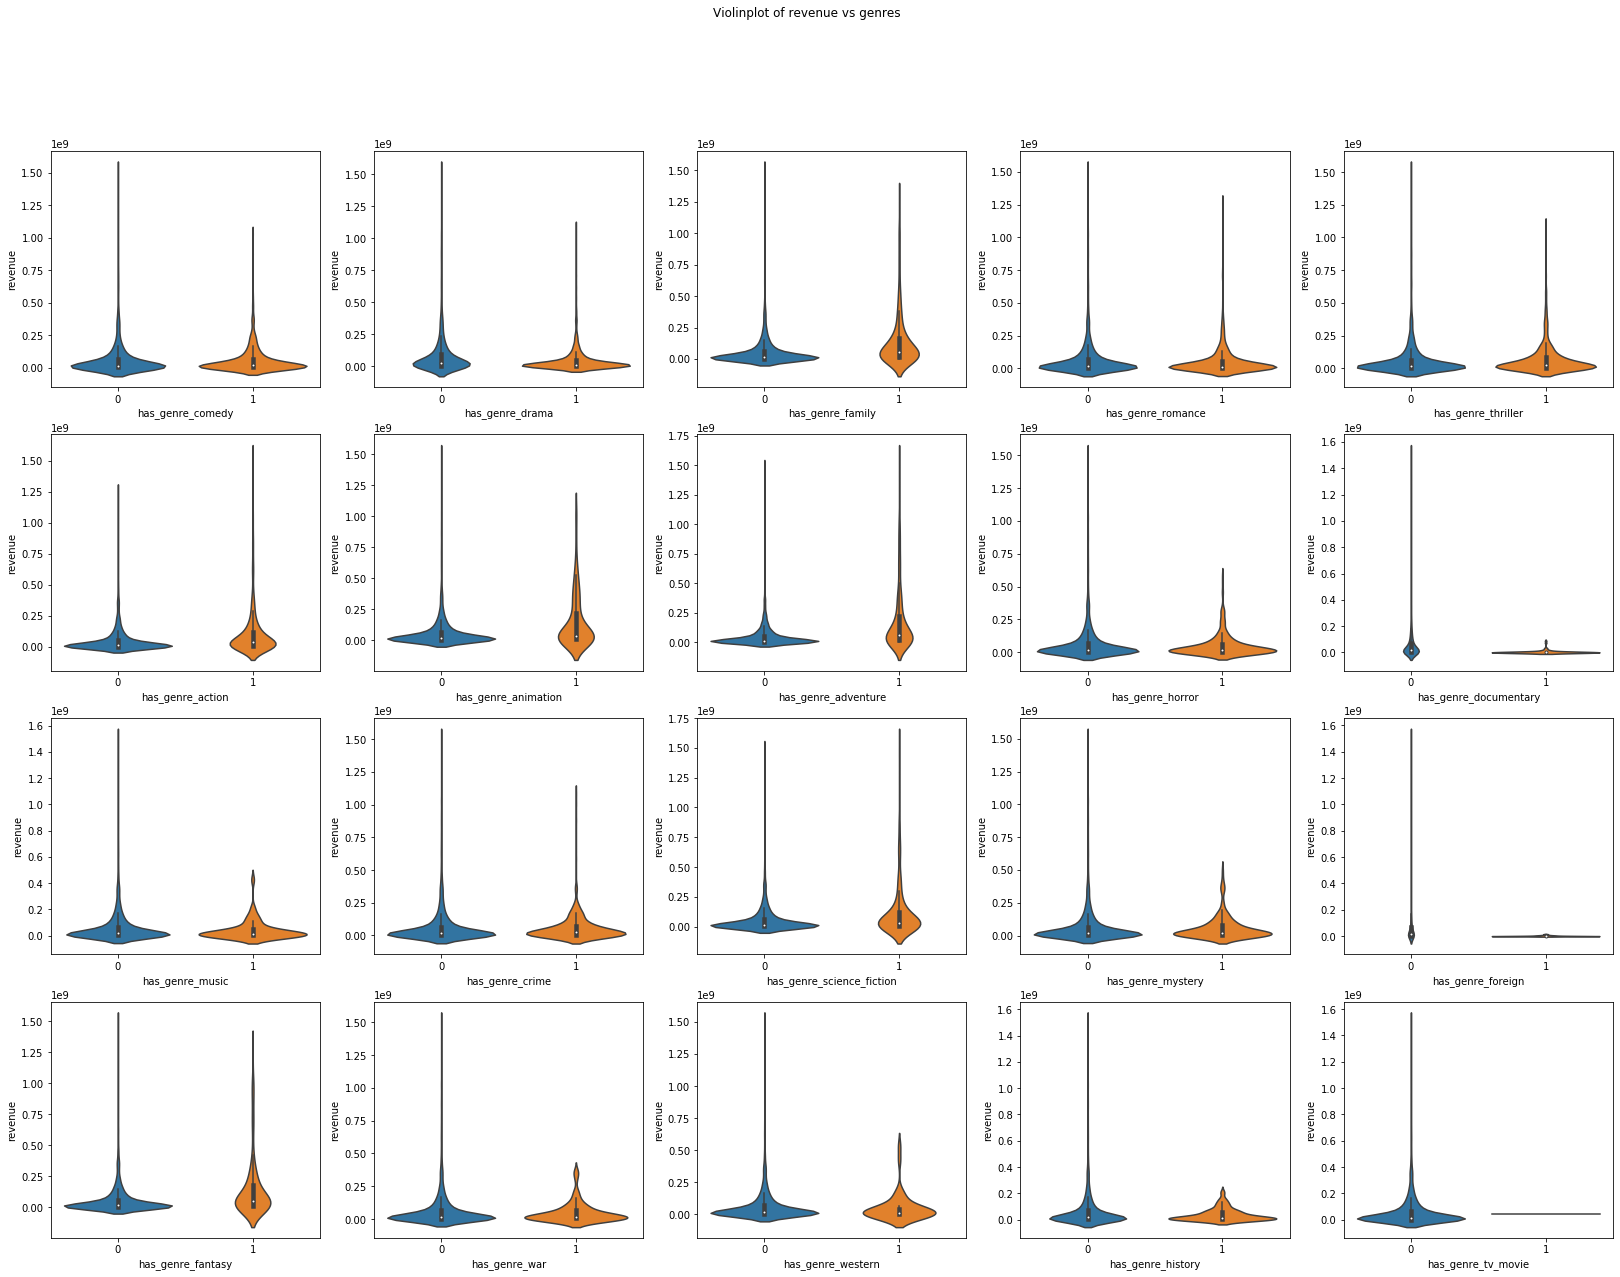

In [35]:
f, axes = plt.subplots(4, 5, figsize=(28, 20))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train_copy.columns if 'has_genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train_copy, ax=axes[i // 5][i % 5]);

A violin plot visualization of all genres. We can see that the different genres are correlated differently with revenue. When the orange violion is flatter and lower than the blue, it means that there is a negative correlation. Examples are ``has_genre_drama`` and ``has_genre_comedy``. When the orange is taller than the blue, it has a positive correlation, like ``has_genre_animation`` and ``has_genre_adventure``.  

### Release date

Next attribute to handle is the release date. It seemed like an important attribute movies realeased earlier in the 20th century probably made less money than movies released today, partially because of inflation too. 

In [37]:
train_copy['release_date']

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
5         8/6/87
6        8/30/12
7        1/15/04
8        2/16/96
9        4/16/03
10      11/21/76
11       7/10/87
12       9/15/99
13        3/4/05
14       6/20/02
15       10/6/10
16        8/4/05
17      12/25/13
18        2/2/11
19        8/2/05
20        4/3/98
21       8/13/82
22       7/28/12
23        9/2/11
24        9/9/06
25      10/23/92
26        9/8/97
27        9/7/13
28        8/8/86
29        4/7/02
          ...   
2970    11/25/92
2971    10/12/90
2972     7/27/06
2973      8/9/85
2974     1/28/05
2975     7/31/09
2976      3/3/00
2977     5/15/01
2978    10/23/98
2979     4/23/10
2980      2/4/16
2981      9/9/16
2982     9/12/12
2983      4/4/97
2984      8/8/03
2985     2/17/06
2986      9/3/04
2987     1/20/89
2988     5/20/02
2989     5/11/01
2990     3/28/97
2991     1/12/01
2992     3/18/24
2993     6/17/04
2994     9/18/92
2995     4/22/94
2996     3/28/13
2997    10/11/

A quick look at how the dates are stored. We are thinking of using the month and the year as own attributes.

In [38]:
def release_date_conv(collection, length):
    month = []
    year = []

    for t in collection['release_date']:
        if t == t:
            split_arr = t.split('/')
            month.append(int(split_arr[0]))

            yearInt = int(split_arr[2])
            if(yearInt < 20):
                year.append(2000 + yearInt)
            else:
                year.append(1900 + yearInt)
        else:
            #FIX ME
            month.append(10)
            year.append(2000)
        
    while len(month) < length:
        month.append(0)
        year.append(0)
    
    collection['release_month'] = month
    collection['release_year'] = year
    
    collection = collection.drop(['release_date'], axis=1)
        
release_date_conv(train_copy, 3000)
release_date_conv(test_copy, 4398)

### Budget 0's manipulation
Here we're fixing budget so that it does not contain zeros. We observed that a lot of rows had budget set to 0, so we tried filling these with the median value instead. 

In [39]:
budget_median = statistics.median(train_copy['budget'])
budget_median

8000000.0

In [40]:
for x in range(0, len(train_copy['budget'])):
    if train_copy['budget'][x] == 0:
        train_copy['budget'][x] = budget_median
        

C:\Users\joste\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Actually this did not do much to improve the overall score. Changing all zeros to the median value made little to no change. We also tried changing all zeros to the average, but that made it worse. Interesting.

### Runtime and status

The runtime function is for converting values from float to int. 
The status function is checking if a movie is released and assigning ``1`` to a new column if it is. 

In [41]:
def runtime_onehot(collection, length):
    newRuntimes = []
    for x in train_copy['runtime']:
        if x == x:
            newRuntimes.append(int(x))
        else:
            newRuntimes.append(0)
    
    while len(newRuntimes) < length:
        newRuntimes.append(0)

    collection['runtime'] = newRuntimes

In [42]:
runtime_onehot(train_copy, 3000)
runtime_onehot(test_copy, 4398)

In [43]:
def status_one_hot(collection):
    statusOnehot = []
    for movie in collection['status']:
        if movie is "Released":
            statusOnehot.append(1)
        else:
            statusOnehot.append(0)
    return statusOnehot

In [44]:
train_copy['status'] = status_one_hot(train_copy)
test_copy['status'] = status_one_hot(test_copy)

In hindsight these functions are not very useful anymore. 

### Dropping columns

What remains now is dropping the non-numeric columns that are still in the test and train datasets. 

In [45]:
train_copy = train_copy.drop(['overview'], axis=1)
train_copy = train_copy.drop(['production_countries'], axis=1)
train_copy = train_copy.drop(['tagline'], axis=1)
train_copy = train_copy.drop(['title'], axis=1)
train_copy = train_copy.drop(['crew'], axis=1)
train_copy = train_copy.drop(['original_title'], axis=1)
train_copy = train_copy.drop(['production_companies'], axis=1)
train_copy = train_copy.drop(['release_date'], axis=1)
train_copy = train_copy.drop(['genres'], axis=1)
train_copy = train_copy.drop(['imdb_id'], axis=1)
train_copy = train_copy.drop(['original_language'], axis=1)
train_copy = train_copy.drop(['poster_path'], axis=1)
train_copy = train_copy.drop(['has_genre_tv_movie'], axis=1) #this genre only appears in the train set; not test set

test_copy = test_copy.drop(['overview'], axis=1)
test_copy = test_copy.drop(['production_countries'], axis=1)
test_copy = test_copy.drop(['tagline'], axis=1)
test_copy = test_copy.drop(['title'], axis=1)
test_copy = test_copy.drop(['crew'], axis=1)
test_copy = test_copy.drop(['original_title'], axis=1)
test_copy = test_copy.drop(['production_companies'], axis=1)
test_copy = test_copy.drop(['release_date'], axis=1)
test_copy = test_copy.drop(['genres'], axis=1)
test_copy = test_copy.drop(['imdb_id'], axis=1)
test_copy = test_copy.drop(['original_language'], axis=1)
test_copy = test_copy.drop(['poster_path'], axis=1)

In [46]:
train_copy = train_copy.fillna(train_copy.median())
test_copy = test_copy.fillna(train_copy.median())

Above we fill in the empty variables with the practical fillna function .

In [47]:
corr_matrix = train_copy.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue                            1.000000
budget                             0.753490
popularity                         0.461460
male_cast_size                     0.383450
crew_size                          0.377210
cast_size                          0.345310
has_collection                     0.339425
has_genre_adventure                0.328439
has_homepage                       0.263179
female_cast_size                   0.230179
runtime                            0.216230
uncategorized_cast_size            0.190991
has_genre_action                   0.184584
keyword_duringcreditsstinger       0.184310
keyword_aftercreditsstinger        0.175838
has_genre_fantasy                  0.171040
num_keywords                       0.163496
has_genre_family                   0.161677
keyword_sequel                     0.151561
release_year                       0.137933
has_genre_science_fiction          0.132367
has_genre_animation                0.130828
has_english                     

## Training

Now: training. We tried using Linear Regression, but ended up using RandomForest Regressor.  

In [48]:
train = train_copy.copy()
X = train.drop(['revenue'], axis=1)
y = train['revenue'].copy()
X_test = test_copy

### Linear

In [49]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
# predictions = lin_reg.predict(train_no_revenue)
# lin_mse = mean_squared_log_error(revenues, predictions)
# lin_rmse = np.sqrt(lin_mse)
# lin_rmse

# WE GET THE RESULT ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
# This means that the model predicts that some movies have a revenue below zero.
# MSLE does not accept this so therefore this is commented out. Let's try something else instead.b

### Forest Regressor

In [51]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 20, 30], 'max_features': [3, 4, 6, 8, 10, 12, 15, 20, 30, 40]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_log_error')
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [3, 4, 6, 8, 1

We tried using Randomized Search on RandomForestRegressor but settled with GridSearch. No perticular reason as we found the results were very similar.

In [53]:
grid_search.best_params_

{'max_features': 40, 'n_estimators': 3}

In [54]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=40, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [55]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2.8883889532122926 {'max_features': 3, 'n_estimators': 3}
2.994166603194487 {'max_features': 3, 'n_estimators': 10}
3.05636156439982 {'max_features': 3, 'n_estimators': 20}
3.0963327188746037 {'max_features': 3, 'n_estimators': 30}
2.8744190214321477 {'max_features': 4, 'n_estimators': 3}
3.0575516514957073 {'max_features': 4, 'n_estimators': 10}
2.9867809426751033 {'max_features': 4, 'n_estimators': 20}
3.0634559770328376 {'max_features': 4, 'n_estimators': 30}
2.849154511932498 {'max_features': 6, 'n_estimators': 3}
2.904334401418617 {'max_features': 6, 'n_estimators': 10}
3.01963103821005 {'max_features': 6, 'n_estimators': 20}
2.9367940560253274 {'max_features': 6, 'n_estimators': 30}
2.8027971463527046 {'max_features': 8, 'n_estimators': 3}
2.8340920058084555 {'max_features': 8, 'n_estimators': 10}
2.8826769223977062 {'max_features': 8, 'n_estimators': 20}
2.913516275035123 {'max_features': 8, 'n_estimators': 30}
2.7690867154491245 {'max_features': 10, 'n_estimators': 3}
3.0043675

In [56]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=40, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [57]:
final_model = grid_search.best_estimator_

## Evaluating RandomForest on test set

In [58]:
X_test = test_copy

final_predictions = final_model.predict(X_test)

In [59]:
subm = pd.DataFrame({'id': test.id, 'revenue': final_predictions})

In [60]:
pd.DataFrame(subm).to_csv("SubmissionRFG.csv", index=False)

This csv file got submitted to kaggle. The best score we got out of all submissions was 2.87447.

Not the best score. To improve this we could've used more advanced models like gradient boosting, or the data could been optimized more. We tried to implement some of these models, but we did not manage to make a functioning version in time.